# <center> Parte 3</center>

---

In [2]:
# modulos necesarios
import numpy as np
import numpy.ma as ma
import numpy.linalg as linalg

import netCDF4 as nc
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

from scipy import stats
from scipy import signal
from scipy.fft import fft 
from scipy.stats.stats import pearsonr

import warnings 
warnings.filterwarnings('ignore')

C:\Users\usuario\AppData\Local\Temp\ipykernel_2724\4159567540.py:17: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


<span style='color:darkred'>**Índice**    </span>

0. [Funciones](#id0)   
1. [Prueba](#id1)
2. [Cálculo de la Matriz de Covarianza](#id2)
3. [Cálculo de la EOF de y PC-s](#id3)


## <a name="id0"><span style='color:darkgreen'>0. Funciones</a>

In [3]:
# cogemos primavera porque fue donde conseguimos la mayor variabilidad
def season(Z,e1,e2,nyrs):
    '''
        para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
        e1 y e2 son los meses inicial y final de las estaciones

        Por ejemplo:
        e1=2 ; e2=4  ; estación = 'MAM' ;
        e1=5 ; e2=7  ; estación = 'JJA' ;
        e1=6 ; e2=8  ; estación = 'JAS' ;
        e1=8 ; e2=10 ; estación = 'SON' ;
        e1=11; e2=1  ; estación = 'DJF' ;
        e1=10; e2=1  ; estación = 'NDJF'
'''
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:, e1:e2, :].mean(1)

    return Zs ,nyrs


# funciones de belen para quitar y poner nans
# =============================================

def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out
    
def pongonans(matred, mat):
    out = mat.mean(axis = 0 )
    out[:] = np.nan
    out[~np.isnan(mat.mean(axis = 0))] = matred
    return out




In [4]:
def anom(X,nyr,par):
    # si par = st, anomalías estandarizadas  
    ns,nt=np.shape(X) 
    nmes=int(nt/nyr)
    An=ma.empty([ns,nt])
    
    A = X.reshape(nyr,nmes,ns)
    mA = np.mean(A,axis=(0,1))

    An = A - mA
    
    if par == 'st':
        An = An/np.std(An,axis=(0,1))

    return An.reshape(ns,nyr*nmes)

# función pearsonr para y 2D, x 1D
def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho


# función para calcular correlaciones y regresiones
def IndexRegression(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    reg=np.dot(Data,Index)/(nt-1)
    
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) 
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor)
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp):
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index))
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)
        
    return cor,Pvalue,cor_sig,reg,reg_sig

# Esta función calcula correlaciones en datos de mas de una dimensión

def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho

# Esta función calcula mapas de Correlacion y Regresion a partir de un índice

def IndexRegrCorr(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    reg=np.dot(Data,Index)/(nt-1)
    
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) 
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor)
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp):
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index))
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)
        
    return cor,Pvalue,cor_sig,reg,reg_sig

    
def dibujo_1_mapa_cartopy(A,lon,lat,levs,cmap1,l1,titulo, ax):
    im=ax.contourf(lon,lat,A
                   ,cmap=cmap1,levels=levs,extend='both',transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=2)
    ax.set_title(titulo,fontsize=28)
    cbar = plt.colorbar(im, extend='neither', spacing='proportional',
                orientation='vertical', shrink=0.7, format="%.0f")
    cbar.set_label(l1, size=28)
    cbar.ax.tick_params(labelsize=28)  

## <a name="id1"><span style='color:darkgreen'>1.Prueba</span></a>

In [5]:
# abro los datos
folder = 'data/'
data   = xr.open_dataset(f'{folder}Tn10p_ESP_nan.nc')

In [6]:
# selecciono la latitud y longitud
lon = data.x
lat = data.y

# aqui tengo los datos de cold nights
variable = data.__xarray_dataarray_variable__

In [7]:
# remallado de los datos ya que para las EOF-s no se necesita tanta resolucion
tn10_remallado = variable.interp(lat=variable.lat[::2]).interp(lon=variable.lon[::2])
tn10_remallado = tn10_remallado.set_index(lon='x')
tn10_remallado = tn10_remallado.set_index(lat='y')

In [8]:
# ahora las latitudes y longitudes tienen diferente dimension
lat=variable.lat[::2]
lon=variable.lon[::2]

Text(0.5, 0.98, 'Porcentaje de noches frías definiendo el percentil con el primer periodo')

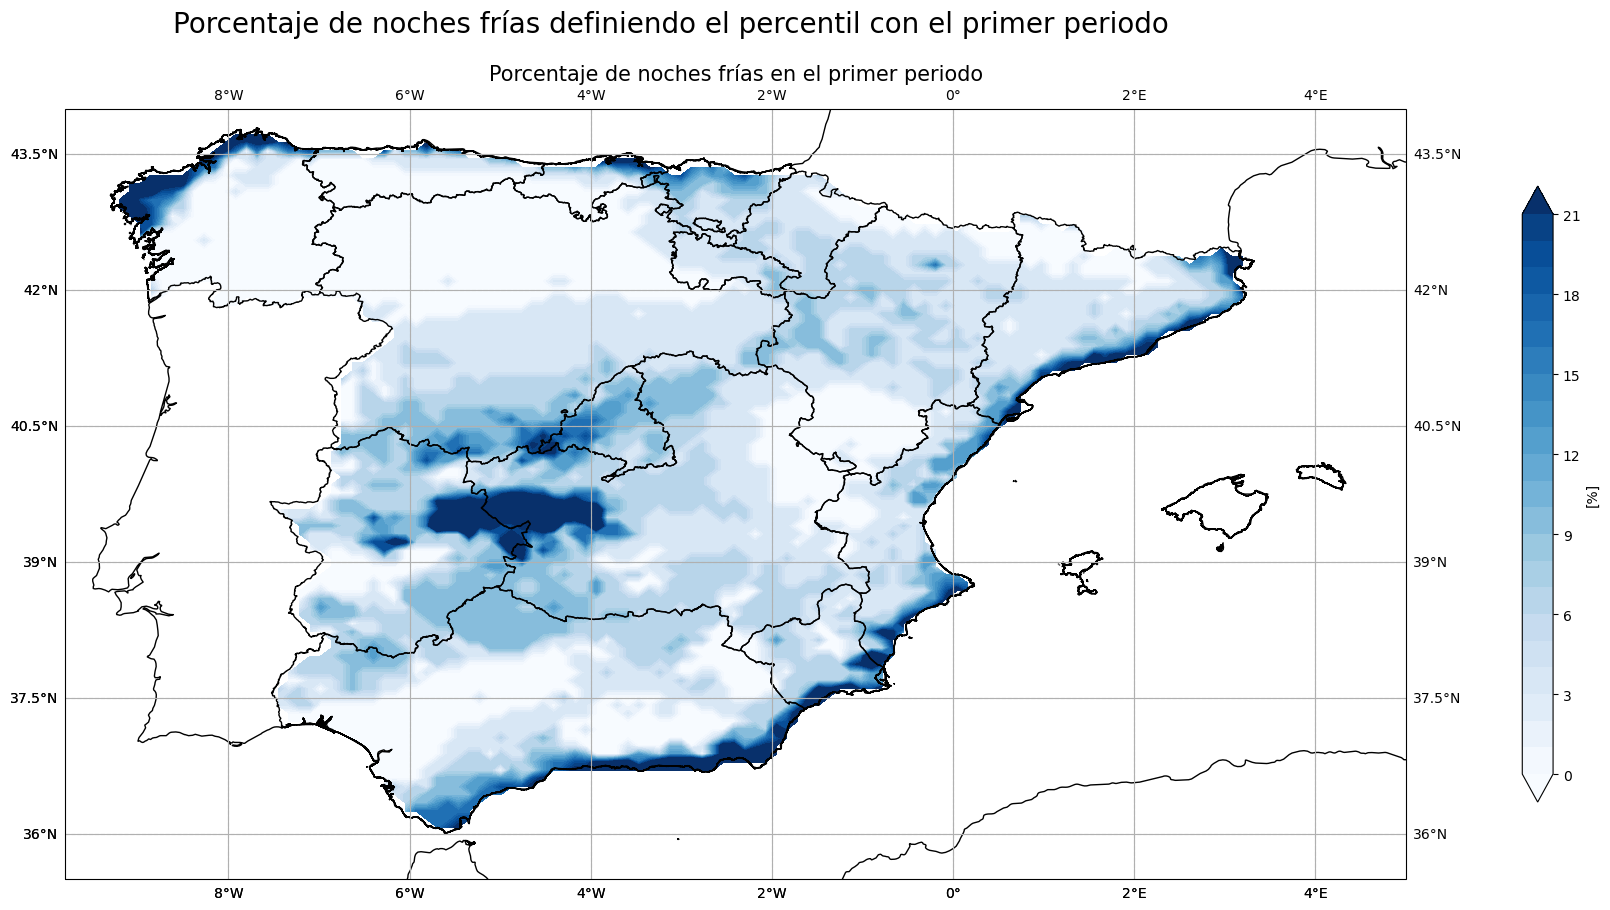

In [9]:
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = 'data/mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())

# selecciono un dia en especifico
perc_1_mean = tn10_remallado.sel(time = '1901-01-01')

# representamos el porcentaje para cada punto de la malla de datos
fig = plt.figure(figsize=(30,10), tight_layout=False) 
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
cbarticks = np.arange(0,22,1)

gl = ax1.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False
 
cmap= 'Blues'
unidades= '[%]'

im=ax1.contourf(perc_1_mean.lon, perc_1_mean.lat, perc_1_mean, cbarticks,cmap = cmap, extend='both', 
                  vmin = 0, vmax = 22)

# pintamos las líneas de costa y las fronteras de comunidades
ax1.coastlines(resolution='10m')
ax1.add_geometries(adm1_shapes, ccrs.PlateCarree(), # cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax1.set_global() 
ax1.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1) # añadimos ejes
ax1.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # fijamos los límites del plot

# determino el colotbar
fig.colorbar(im,ax=ax1,shrink=0.8, label=unidades,orientation='vertical')

# titulo superior y titulos - ESTO DEBERÍA CAMBIARLO
ax1.set_title('Porcentaje de noches frías en el primer periodo',fontsize=15)
fig.suptitle('Porcentaje de noches frías definiendo el percentil con el primer periodo',
             fontsize = 20)

## <a name="id2"><span style='color:darkgreen'>2. Cálculo de la matriz de covarianza y diagonalización</span></a>

In [10]:
# la matriz de covarianza la cual multiplicamos por
# un índice debe estar estandarizada
# recuerda covarianza -> anomalias estandarizadas
# correlacion -> anomalias

In [11]:
# dimesiones y las guardos
ntime, nlat, nlon = tn10_remallado.shape

# hago un reshape para poder usar la función season
variable_reshaped = np.reshape(tn10_remallado, (int(ntime/12), 12, nlat*nlon))

# agrupo por meses en primavera
tn10_primavera = season(np.asarray(variable_reshaped), 2, 4, ntime/12)[0]
# elijo el [0] porque devuelve otro dato que no se usa

In [12]:
# manera de contar la cantidad de True que tengo
bool_array = np.isnan(tn10_primavera)
print(len(tn10_primavera[1])*len(tn10_primavera[0]))
np.count_nonzero(bool_array)

# con esto argumento que de 119355625 datos que tenfo solo
# 669864 son nan

119355625


669864

In [13]:
# voy a quitar los nans
y2 = quitonans(tn10_primavera)

In [14]:
# debo normalizar mis datos creo - le quito la media temporal
y2 = (y2 - y2.mean(axis=0))/y2.std()

# todo son nans en el tiempo vamos que algo estoy haciendo mal
np.count_nonzero(np.isnan(y2.mean(axis=1)))

# calculo de la matriz de covarianza
C = np.dot(np.transpose(y2), y2) # ns*ns 

# aquí tengo que meter espacio, espacio por eso meto la transpuesta
R, d, R = linalg.svd(C)

In [15]:
# cuando de la varibilidad explico con cada valor propio?
fvar = d/sum(d)

# con los 5 primeros autovectores/autovalores reconstruyo 
# aproximadamente el 80 % de la varianza
sum(fvar[:5])

0.7824248156890149

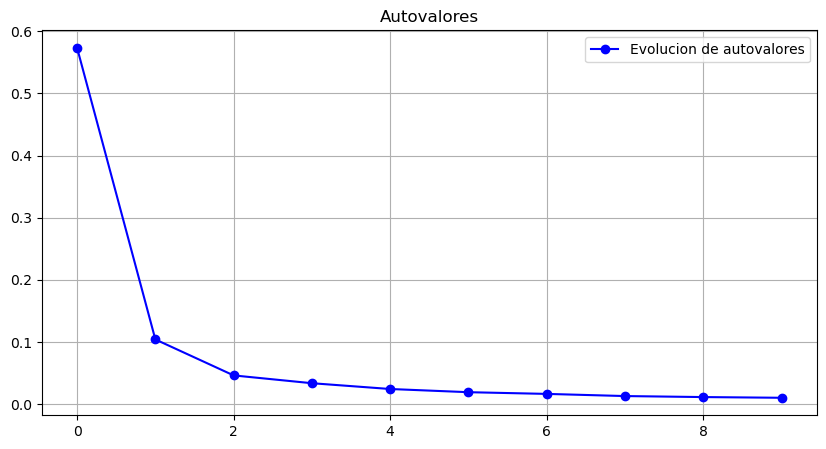

In [16]:
# plot de la distribución de mis eingenvalues
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar[:10],color='Blue',marker='o', label='Evolucion de autovalores')
plt.title('Autovalores')
plt.legend()
plt.grid()

## <a name="id3"><span style='color:darkgreen'>3. Cálculo de la EOF y PC-s</span></a>

In [17]:
# numero de modos para explicar mi variabilidad
num_modos = 5
pc = np.dot(y2, R[:, :num_modos + 1])

In [18]:
# estandarizo las componentes principales
pc_std = (pc-np.mean(pc))/np.std(pc)

In [19]:
tn10_primavera.shape, y2.shape

((114, 10925), (114, 5049))

In [20]:
# calculo la eof correspondiente a esta pc
# (espacio, tiempo)*tiempo
# me falta ponen nans
Y1 = np.nan_to_num(tn10_primavera,nan=-999)

cor1,Pvalue1,cor_sig1,reg1,reg1_sig = IndexRegrCorr(np.transpose(Y1), pc_std[:,0], 0.01, 'MonteCarlo', 100)

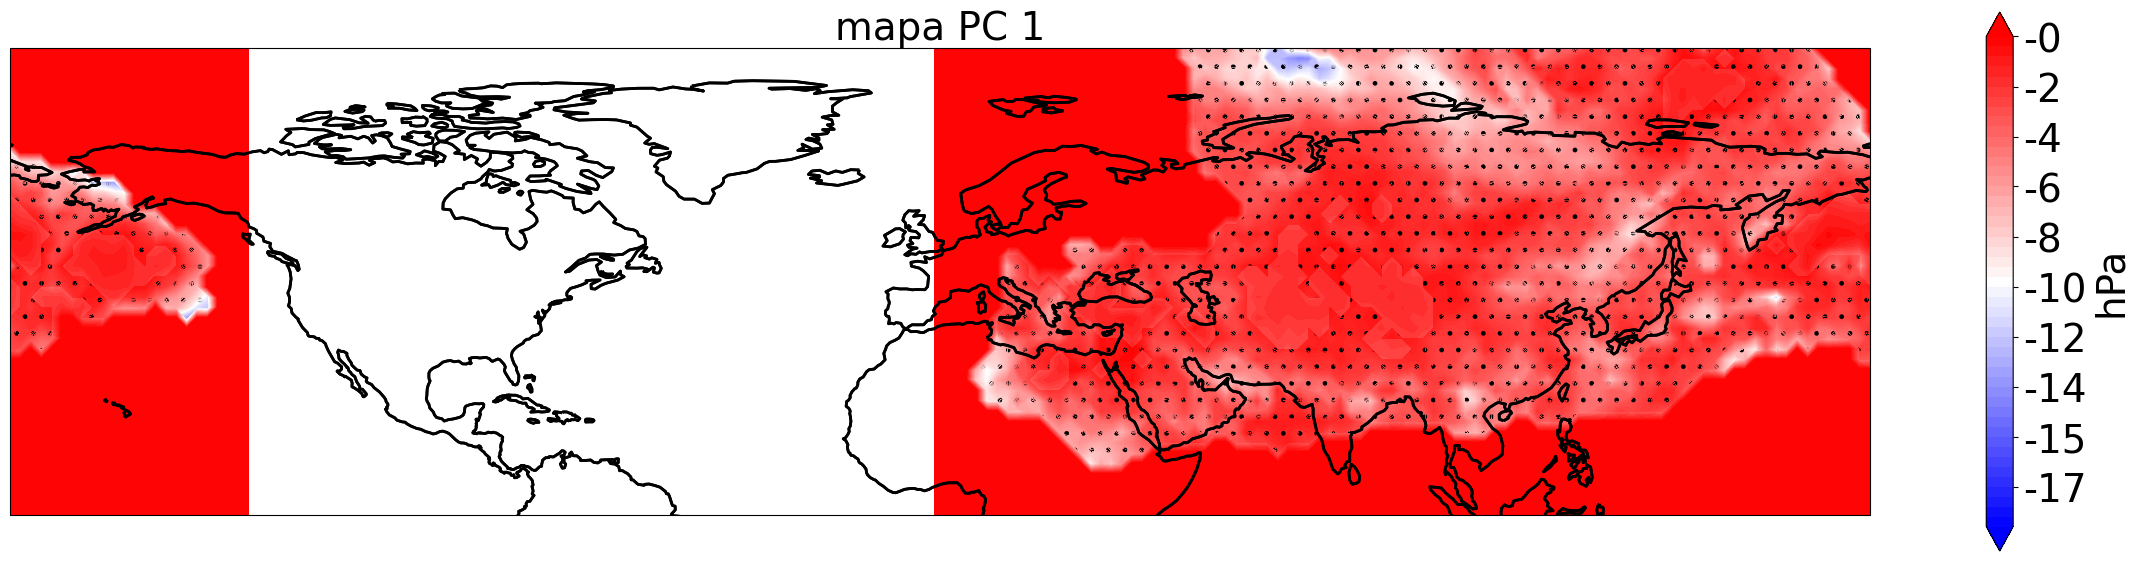

In [21]:
# figura de la EOF utilizando el primer autovalor
fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg1,(nlat,nlon)),lon,lat,np.linspace(reg1.min(),reg1.max(),50),'bwr','hPa','mapa PC 1', ax)
ax.contourf(lon,lat,np.reshape(reg1_sig,(nlat,nlon)),cmap='bwr',levels=np.linspace(reg1_sig.min(),reg1_sig.max(),100),hatches='.')
  
ax.coastlines(linewidth=2)

Text(0.5, 1.0, 'Primera componente principal fvar=0.57')

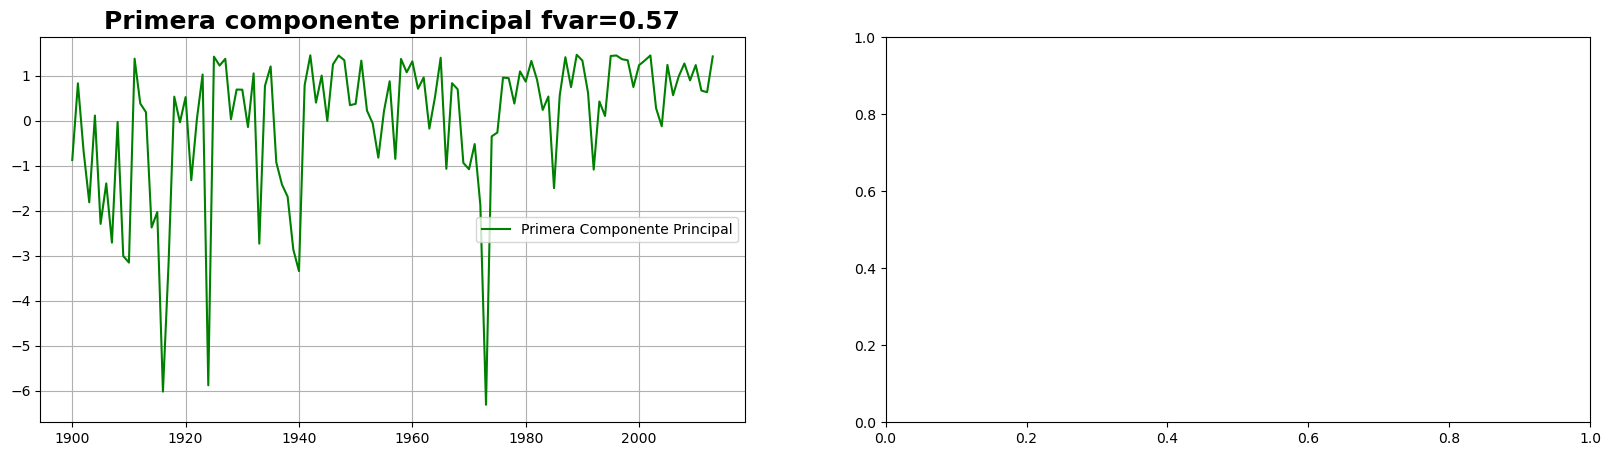

In [30]:
# primera componente principal y la variabilidad que explica
fig,ax = plt.subplots(nrows=1, ncols= 2, figsize = (20,5))
ax[0].plot(range(1900,2014),pc_std[:,0],color='green',label='Primera Componente Principal')
ax[0].grid()
ax[0].legend()
ax[0].set_title('Primera componente principal fvar='+ str( round(fvar[0],2)),fontsize=18,weight='bold')

# eof

Text(0.5, 1.0, 'Segunda componente principal fvar=0.1')

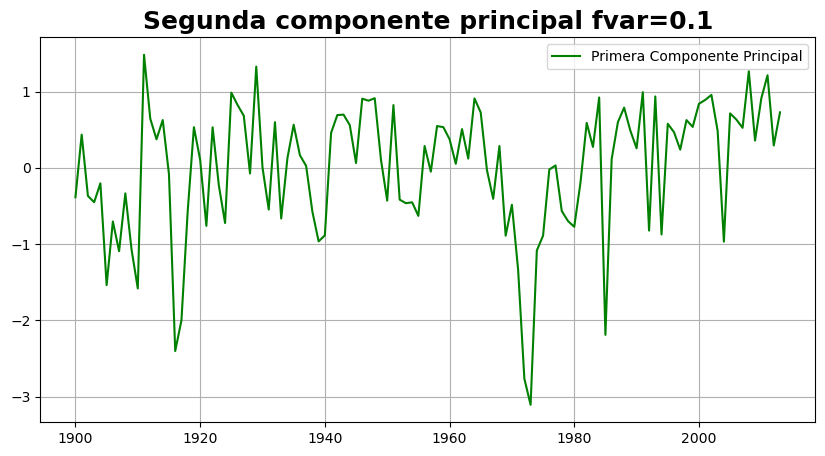

In [28]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),pc_std[:,1],color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Segunda componente principal fvar='+ str(round(fvar[1],2)),fontsize=18,weight='bold')